<a href="https://colab.research.google.com/github/SteveHong1901/CSS-hackathon-coding-curriculum/blob/main/FNA_LSE_Datathon_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem statement: Cross Border Banking Exposures - Research option 1**
# Team Name: The First-Year Underdogs
# Members: Myungchan Kim, Xiaocheng Liang, Steve Hong

In [ ]:
pip install numpy pandas matplotlib sklearn PyOD seaborn

In [ ]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
claim = pd.read_csv("/content/bis_arcs-1.csv")
code = pd.read_csv("/content/bis_vertices-1.csv")

In [ ]:
code_dis = code["vertex_id"].unique()
print(code_dis)
print("Nummber of countries recorded: ",len(code_dis))

['5A' 'AU' 'AT' 'BE' 'CA' 'CL' 'TW' 'FI' 'FR' 'DE' 'GR' 'IN' 'IE' 'IT'
 'JP' 'NL' 'PT' 'KR' 'ES' 'SE' 'CH' 'TR' 'GB' 'US']
Nummber of countries recorded:  24


In [ ]:
print(claim["net_id"].unique())

['2005-06-30' '2005-09-30' '2005-12-31' '2006-03-31' '2006-06-30'
 '2006-09-30' '2006-12-31' '2007-03-31' '2007-06-30' '2007-09-30'
 '2007-12-31' '2008-03-31' '2008-06-30' '2008-09-30' '2008-12-31'
 '2009-03-31' '2009-06-30' '2009-09-30' '2009-12-31' '2010-03-31'
 '2010-06-30' '2010-09-30' '2010-12-31' '2011-03-31' '2011-06-30'
 '2011-09-30' '2011-12-31' '2012-03-31' '2012-06-30' '2012-09-30'
 '2012-12-31' '2013-03-31' '2013-06-30' '2013-09-30' '2013-12-31'
 '2014-03-31' '2014-06-30' '2014-09-30' '2014-12-31' '2015-03-31'
 '2015-06-30' '2015-09-30' '2015-12-31' '2016-03-31' '2016-06-30'
 '2016-09-30' '2016-12-31' '2017-03-31' '2017-06-30' '2017-09-30'
 '2017-12-31' '2018-03-31' '2018-06-30' '2018-09-30' '2018-12-31'
 '2019-03-31' '2019-06-30' '2019-09-30' '2019-12-31' '2020-03-31'
 '2020-06-30' '2020-09-30' '2020-12-31' '2021-03-31']


In [ ]:
code

,net_id,vertex_id,country
0,2005-06-30,5A,All reporting countries
1,2005-06-30,AU,Australia
2,2005-06-30,AT,Austria
3,2005-06-30,BE,Belgium
4,2005-06-30,CA,Canada
...,...,...,...
1531,2021-03-31,SE,Sweden
1532,2021-03-31,CH,Switzerland
1533,2021-03-31,TR,Turkey
1534,2021-03-31,GB,United Kingdom


**TRANSFORMING THE DATA**
- It is observed that the "arc" dataset describes a network in long data form.
- The idea of the adjacency matrix from network theory was used to transform the data.
- The columns represent "to_id," which is the government that owns a foreign asset while the row is the corresponding counter party.
- In terms of network theory, the data can be seen as a weighted and directed network (with each weight representing the value of assets and direction representing ownership).

**Some Considerations**

In order to create the matrix, a .pivot() function was used. In this situation, it can be safely assumed that there are no self-loops (meaning the diagonal elements must be 0): with cross-boarder claims, it would only make sense if a country had no cross border claim on itself.


Also, it was observed that not all countries were involved in every single quarter. For data consistency, these were added in and assumed to be 0.

**Illustration on one quarter**

In [ ]:
claim_2010_06_30 = claim[claim["net_id"] == "2010-06-30"]                                             #Filter the DF for for 24 countries of quarter 2010-06-30	

transformed_claim1 = claim_2010_06_30.pivot(index= "from_id", columns = "to_id", values = "value")    #Pivot the table so that a matrix is formed

transformed_claim1 = transformed_claim1.fillna(0)                                                     #Replace the self-loops with 0

transformed_claim1 = transformed_claim1.sort_index(axis=1)                                            #Sort the columns in alphabetical order

transformed_claim1 = transformed_claim1.drop("5A",axis = 1)                                           #Omit the column of individual countries vs the rest of the world

index = transformed_claim1.index.union(transformed_claim1.columns)                                    #Find the full list of countries

transformed_claim1 = transformed_claim1.reindex(index = index, columns = index, fill_value=0)         #Add the missing rows/columns, replace missing cells with 0

transformed_claim1.head()

,AT,AU,BE,CA,CH,CL,DE,ES,FI,FR,GB,GR,IE,IN,IT,JP,KR,NL,PT,SE,TR,TW,US
AT,0.0,275.0,2749.0,1081.0,10878.0,0.0,85842.0,4804.0,357.0,21266.0,8805.0,107.0,4928.0,0.0,121160.0,6586.0,0.0,8894.0,305.0,1374.0,745.0,445.0,8606.0
AU,1859.0,0.0,2231.0,24061.0,0.0,0.0,42731.0,3776.0,211.0,31690.0,91991.0,27.0,6108.0,0.0,2999.0,86029.0,0.0,65576.0,451.0,1924.0,90.0,5828.0,84585.0
BE,3488.0,1017.0,0.0,2463.0,0.0,0.0,35141.0,5861.0,434.0,253684.0,29539.0,173.0,5759.0,0.0,4309.0,15889.0,0.0,0.0,411.0,3242.0,830.0,772.0,42829.0
CA,1564.0,12486.0,2257.0,0.0,17623.0,8.0,29672.0,1669.0,184.0,28759.0,87257.0,53.0,11274.0,0.0,2818.0,53545.0,0.0,45438.0,404.0,2466.0,31.0,910.0,117692.0
CH,12620.0,5896.0,1299.0,4632.0,0.0,0.0,55927.0,6466.0,453.0,55753.0,39341.0,941.0,6776.0,0.0,10511.0,22276.0,0.0,17384.0,2257.0,3505.0,496.0,2566.0,81429.0


**DATA PROCESSING**
- A steep percentage change in sovereign borrowing over consecutive quarters can be an accurate representation of a signal for debt crises.
- Percentage change rather than nominal values were used as a way to normalise the values. (So that transactions with high values don't dominate in the model)

- $\text{Percentage Change =}\frac{quarter (n+1)-quarter(n)}{quarter(n)}*100$
- In the case of $\text {quarter(n) = 0, quarter(n+1) =0}$, the result would be returned as +-inf, which can dominate other anomalies in the next steps. This can be rectified by replacing them with 0.




In [ ]:
#Repeating the Data Transfromation step to find the values in year(n+1). The year(n) network was already obtained from above

claim_2010_09_30 = claim[claim["net_id"] == "2010-09-30"]                                             #Filter the DF for for 24 countries of quarter 2010-09-30

transformed_claim2 = claim_2010_09_30.pivot(index= "from_id", columns = "to_id", values = "value")    #Pivot the table so that a matrix is formed

transformed_claim2 = transformed_claim2.fillna(0)                                                     #Replace the self-loops with 0

transformed_claim2 = transformed_claim2.sort_index(axis=1)                                            #Sort the columns in alphabetical order

transformed_claim2 = transformed_claim2.drop("5A",axis = 1)                                           #Omit the column of individual countries vs the rest of the world

index = transformed_claim2.index.union(transformed_claim2.columns)                                    #Find the full list of countries

transformed_claim2 = transformed_claim2.reindex(index = index, columns = index, fill_value=0)         #Add the missing rows/columns, replace missing cells with 0

transformed_claim2.head()

,AT,AU,BE,CA,CH,CL,DE,ES,FI,FR,GB,GR,IE,IN,IT,JP,KR,NL,PT,SE,TR,TW,US
AT,0.0,303.0,3226.0,1275.0,11236.0,0.0,92496.0,4420.0,410.0,23050.0,10115.0,337.0,5636.0,0.0,112483.0,6769.0,0.0,9998.0,511.0,1393.0,646.0,416.0,9293.0
AU,1828.0,0.0,2401.0,24248.0,0.0,28.0,38377.0,4005.0,223.0,33051.0,93186.0,37.0,6152.0,0.0,3280.0,100222.0,0.0,74504.0,489.0,2178.0,19.0,6229.0,98613.0
BE,2743.0,1003.0,0.0,3106.0,0.0,5.0,41280.0,4785.0,462.0,283355.0,28992.0,658.0,6248.0,0.0,4895.0,17539.0,0.0,0.0,768.0,4154.0,612.0,788.0,34615.0
CA,1302.0,14476.0,2249.0,0.0,23136.0,22.0,28891.0,1610.0,134.0,30030.0,84278.0,57.0,11601.0,0.0,3573.0,53887.0,0.0,45415.0,384.0,2214.0,27.0,915.0,115601.0
CH,10462.0,6688.0,2035.0,3986.0,0.0,10.0,55706.0,10368.0,382.0,66318.0,48677.0,901.0,7129.0,0.0,11955.0,24373.0,0.0,25635.0,2467.0,2916.0,427.0,3380.0,40847.0


In [ ]:
per_change = round(((transformed_claim1-transformed_claim2)/transformed_claim1)*100,2)
per_change = per_change.replace([np.inf, -np.inf], 0).fillna(0)
per_change.head()

,AT,AU,BE,CA,CH,CL,DE,ES,FI,FR,GB,GR,IE,IN,IT,JP,KR,NL,PT,SE,TR,TW,US
AT,0.00,-10.18,-17.35,-17.95,-3.29,0.0,-7.75,7.99,-14.85,-8.39,-14.88,-214.95,-14.37,0.0,7.16,-2.78,0.0,-12.41,-67.54,-1.38,13.29,6.52,-7.98
AU,1.67,0.00,-7.62,-0.78,0.00,0.0,10.19,-6.06,-5.69,-4.29,-1.30,-37.04,-0.72,0.0,-9.37,-16.50,0.0,-13.61,-8.43,-13.20,78.89,-6.88,-16.58
BE,21.36,1.38,0.00,-26.11,0.00,0.0,-17.47,18.36,-6.45,-11.70,1.85,-280.35,-8.49,0.0,-13.60,-10.38,0.0,0.00,-86.86,-28.13,26.27,-2.07,19.18
CA,16.75,-15.94,0.35,0.00,-31.28,-175.0,2.63,3.54,27.17,-4.42,3.41,-7.55,-2.90,0.0,-26.79,-0.64,0.0,0.05,4.95,10.22,12.90,-0.55,1.78
CH,17.10,-13.43,-56.66,13.95,0.00,0.0,0.40,-60.35,15.67,-18.95,-23.73,4.25,-5.21,0.0,-13.74,-9.41,0.0,-47.46,-9.30,16.80,13.91,-31.72,49.84


**APPLY TO TO ALL QUARTERS IN THE DATASET**




- The discussed processing method could be applied to 64 quarters in the dataset, each will return a matrix of percentage changes. We can then save these into a list for further modelling. 

In [ ]:
big_list = []                                                                                     #List of 64 DataFrames(DF) of 64 quarters from 2005 to 2021

for date in claim["net_id"].unique():                                                             #Loop through each quarter
    claim_date = claim[claim["net_id"] == date]                                                   #Filter the DF for for 24 countries of one quarter
    transformed_claim = claim_date.pivot(index= "from_id", columns = "to_id", values = "value")   
    transformed_claim = transformed_claim.fillna(0)
    transformed_claim = transformed_claim.sort_index(axis=1)
    transformed_claim = transformed_claim.drop("5A",axis = 1)

    index = transformed_claim.index.union(transformed_claim.columns)

    transformed_claim = transformed_claim.reindex(index = index, columns = index, fill_value=0)

    big_list.append(transformed_claim)

In [ ]:
diff_list = []
for n in (range(len(big_list)-1)):
    per_change = round(((big_list[n+1]-big_list[n])/big_list[n])*100,2)
    per_change = per_change.replace([np.inf, -np.inf], 0).fillna(0)
    diff_list.append(per_change)

**MODELLING**




 **Model 1: Histogram-based Outlier Detection (HBOS)**
HBOS assumes the feature independence and calculates the degree of anomalies by building histograms. 

In [ ]:
from pyod.models.hbos import HBOS 

X = np.array(diff_list).flatten().reshape(-1,1)

outliers_fraction = 0.01
clf = HBOS(contamination=outliers_fraction)
clf.fit(X)
scores_pred = clf.decision_function(X) * -1
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize=(8, 8))

anomaly_HBOS = np.array(y_pred)

#Derive the location of the anomalous countries on the network

indices = [i for i,x in enumerate(anomaly_HBOS) if x == 1]
quarter_of_anomaly = [i//23**2 for i in indices]
country_order = [i%23**2 for i in indices]

print("The order in array form: ", indices)
print("The order in quater: ", quarter_of_anomaly)
print("The country's order in according quater: ", country_order)

The order in array form:  [74, 3079, 4427, 10775, 12105, 13949, 15007, 15392, 15438, 23411, 24653, 25780, 28701, 30012, 30280, 31599, 31875]
The order in quater:  [0, 5, 8, 20, 22, 26, 28, 29, 29, 44, 46, 48, 54, 56, 57, 59, 60]
The country's order in according quater:  [74, 434, 195, 195, 467, 195, 195, 51, 97, 135, 319, 388, 135, 388, 127, 388, 135]


<Figure size 576x576 with 0 Axes>

**Obtaining the country names:** the name of the countries detected could be obtained by finding their indices (derived from their position on the flattened array) and their code from the "Code" dataframe

In [ ]:
#Find the values of row and col

country_row = [i//23 for i in country_order]
country_col = [i%23 for i in country_order]

output_code = claim["from_id"].unique()[country_row]


output_country = []
for i in range(len(output_code)):
  m = code[code["vertex_id"] == output_code[i]]["country"].unique()
  output_country.append(m)

output_country = np.concatenate(output_country, axis=None)

output_country


array(['Canada', 'Switzerland', 'Greece', 'Greece', 'United Kingdom',
       'Greece', 'Greece', 'Belgium', 'Chile', 'Finland', 'Netherlands',
       'Spain', 'Finland', 'Spain', 'Finland', 'Spain', 'Finland'],
      dtype=object)

**Visualising the Results**
In this small section, the threshold for what counts as an outlier will be found. Also, different plots will be shown to evaluate how the model might've performed.

Text(0.5, 1.0, 'Plot Showing the threshold between Inlier and Outlier')

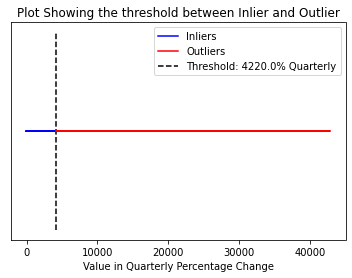

In [ ]:
inlier_X = X[anomaly_HBOS == 0]
outlier_X = X[anomaly_HBOS == 1]

plt.plot(inlier_X,np.zeros(inlier_X.shape), c='Blue')
plt.plot(outlier_X,np.zeros(outlier_X.shape), c='Red')
plt.vlines(np.amin(outlier_X),-0.1,0.1,linestyle='--')
plt.xlabel("Value in Quarterly Percentage Change")
plt.yticks([])

plt.legend(['Inliers','Outliers',f'Threshold: {np.amin(outlier_X)}% Quarterly'])
plt.title('Plot Showing the threshold between Inlier and Outlier')

Note that the threshold seems to be a very high percentage. This percentage is the change is exposure for one country to the other. An insight from this is that a sudden increase in exposure might be a tell-tale sign of troubles. Although this was suspected from the beginning, the data gives more evidence to this.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Total Distribution of Inliers')

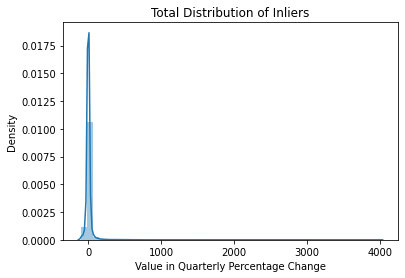

In [ ]:
sns.distplot(inlier_X)
plt.xlabel("Value in Quarterly Percentage Change")
plt.title("Total Distribution of Inliers")

**Evaluation**

An interesting observation is that the inliers seem to be focused around 0% quarterly change (which is expected) while there is a very large range of values that have been classified as non-anomalous but is spaced very sparsely. A more realistic threshold would've been nearer to 200% as seen in the following density plot. 

We believe that this was due to the outlier_fractions parameter which is essentially a first approximation of the proportion of the data that is anomalous. According to literature, this value is usually determined by trial and error. This section would have formed a part of this process. The plot suggests that the outlier fraction was too high (it classified more outliers than it had to) and further investigation would be needed to determine this metric.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(-100.0, 200.0)

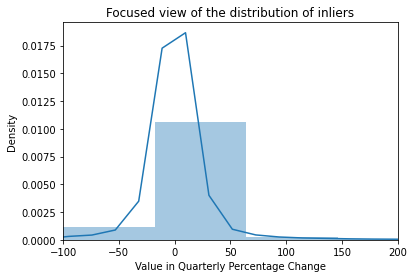

In [ ]:
sns.distplot(inlier_X)
plt.xlabel("Value in Quarterly Percentage Change")
plt.title("Focused view of the distribution of inliers")
plt.xlim([-100,200])

Text(0.5, 0, 'Countries')

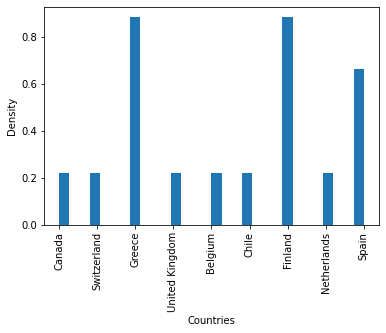

In [ ]:
plt.hist(output_country, density=True, bins=30)  # density=False would make counts
plt.xticks(rotation=90)
plt.ylabel('Density')
plt.xlabel('Countries')

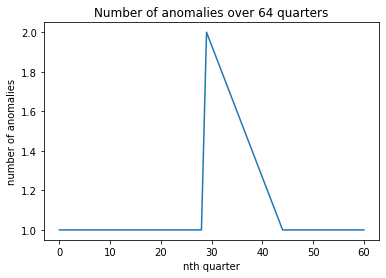

In [ ]:
np.array(quarter_of_anomaly)
(unique, counts) = np.unique(quarter_of_anomaly, return_counts=True)
plt.plot(unique,counts)
plt.title('Number of anomalies over 64 quarters')
plt.xlabel('nth quarter')
plt.ylabel('number of anomalies')
plt.show()

In terms of key statistical values:

In [ ]:
from scipy import stats
print(stats.describe(inlier_X))

DescribeResult(nobs=33310, minmax=(array([-100.]), array([4000.])), mean=array([7.26547043]), variance=array([9857.32032401]), skewness=array([22.64059116]), kurtosis=array([655.27255497]))


**Model 2: Isolation Forest**


Isolation Forest isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of that selected feature.

In [ ]:
from sklearn.ensemble import IsolationForest

outliers_fraction = 0.01
clf = IsolationForest(contamination=outliers_fraction,random_state=0)
clf.fit(X)
scores_pred = clf.decision_function(X) * -1

y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize=(8, 8))

anomaly_IsolationForest = y_pred

##############################################################

indices_IF = [i for i,x in enumerate(anomaly_IsolationForest) if x == 1]
quarter_of_anomaly_IF = [i//23**2 for i in indices]
country_order_IF = [i%23**2 for i in indices]

print("The order in array form: ", indices_IF)
print("The order in quarter: ", quarter_of_anomaly_IF)
print("The country's order in according quater: ", country_order_IF)

##############################################################

country_row_IF = [i//23 for i in country_order]
country_col_IF = [i%23 for i in country_order]


output_code_IF = claim["to_id"].unique()[country_row_IF]

output_country_IF = []
for i in range(len(output_code_IF)):
  m = code[code["vertex_id"] == output_code_IF[i]]["country"].unique().astype(str)
  output_country_IF.append(m)

output_country_IF = np.concatenate(output_country_IF, axis=None)

output_country_IF

############################################################    


The order in array form:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 2

array(['Chinese Taipei', 'Switzerland', 'Japan', 'Japan', 'Canada',
       'Japan', 'Japan', 'Belgium', 'France', 'Germany', 'Turkey',
       'Australia', 'Germany', 'Australia', 'Germany', 'Australia',
       'Germany'], dtype='<U14')

<Figure size 576x576 with 0 Axes>

**Visualising the Results**

Text(0.5, 0, 'Countries')

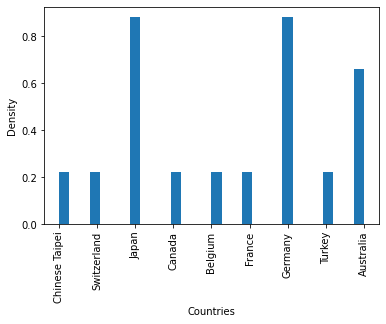

In [ ]:
plt.hist(output_country_IF, density=True, bins=30)  # density=False would make counts
plt.xticks(rotation=90)
plt.ylabel('Density')
plt.xlabel('Countries')

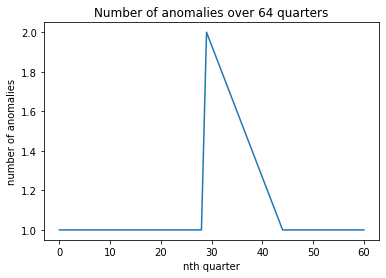

In [ ]:
np.array(quarter_of_anomaly_IF)
(unique, counts) = np.unique(quarter_of_anomaly_IF, return_counts=True)
plt.plot(unique,counts)
plt.title('Number of anomalies over 64 quarters')
plt.xlabel('nth quarter')
plt.ylabel('number of anomalies')
plt.show()

**Evaluation**

A notable exception is Japan given in the Isolation Forest model. However, given that Japan has had a history with sovereign debt, this may require a more complex model to account for this finding.

Also the same model showed anomalies in Australia which could suggest a shortcoming (false-signal) coming from the model.

